In [8]:
from typing import Tuple, Optional, Dict, List
import random
import torch
from torch import Tensor
from torchvision.transforms.functional import pil_to_tensor

In [9]:
torch.device("cuda")


device(type='cuda')

In [10]:
from torchvision.datasets import MNIST
# help(MNIST)

mnist_data =  MNIST(root=".", download=True)

In [11]:
type(mnist_data)
sample = mnist_data[0]
MNIST_SIZE = pil_to_tensor(sample[0]).size()[1:]

display(sample[0]), print(sample[1]), MNIST_SIZE

5


(None, None, torch.Size([28, 28]))

In [29]:
def transform_img(img: "Image"):
    intermediate_img: Tensor = pil_to_tensor(img)
    return intermediate_img / 255

In [71]:
import logging
logger = logging.getLogger(__name__)
logger = logging.getLogger("This")
logger.setLevel(logging.INFO)

# TODO change all layer to torch.nn.LAYERTYPE


class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # self.inp_layer: Tensor =  torch.rand(size=(MNIST_SIZE[0] * MNIST_SIZE[1], 20)).to(float)  # hidden dim=20
        self.inp_layer: Tensor =  torch.nn.Linear(in_features=MNIST_SIZE[0] * MNIST_SIZE[1], out_features=20)
        # self.bias1: Tensor = torch.rand(20)
        # self.layer2_mu: Tensor = torch.rand(size=(20, 5)).to(float)
        self.layer2_mu: Tensor = torch.nn.Linear(in_features=20, out_features=5)
        # self.layer2_sigma: Tensor = torch.rand(size=(20, 5)).to(float)
        self.layer2_sigma: Tensor = torch.nn.Linear(in_features=20, out_features=5)
        # self.bias2_mu: Tensor = torch.rand(size=(1, 5))
        # self.bias2_sigma: Tensor = torch.rand(size=(1, 5))
        self.distr: Optional[torch.distributions.Normal] = None
        return None

    def __forward__(self, x: Tensor):
        # encoder returns mu and log sigma^2
        x = self.inp_layer(x)
        x = torch.functional.F.tanh(x)
        mu = self.layer2_mu(x)
        log_sigma = self.layer2_sigma(x)
        return (mu, log_sigma)

    def __call__(self, x: Tensor):
        return self.__forward__(x)


class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # 5 -> 100
        # 100 -> 784
        self.inp_layer: torch.nn.Linear = torch.nn.Linear(in_features=5, out_features=100)
        self.layer_1_mu: torch.nn.Linear = torch.nn.Linear(in_features=100, out_features=784)
        self.layer_1_sigma: torch.nn.Linear = torch.nn.Linear(in_features=100, out_features=784)
        return None
        
    def __forward__(self, x: Tensor):
        logger.info(x.size())
        x = self.inp_layer(x)
        logger.info(x.size())
        x = torch.functional.F.tanh(x)
        logger.info(x.size())
        mu = self.layer_1_mu(x)
        log_sigma = self.layer_1_sigma(x)
        logger.info((mu.size(), log_sigma.size()))
        return (mu, log_sigma)

    def __call__(self, x: Tensor):
        return self.__forward__(x)

class VAE(torch.nn.Module):
    def __init__(self, enc: Encoder, dec: Decoder):
        super(VAE, self).__init__()
        self.enc = enc
        self.dec = dec

    def __forward__(self, x: Tensor) -> Tensor:
        x_enc: Tuple[Tensor, Tensor] =  self.enc(x)
        latent_norm_enc: Dict[str, Tensor] = {"loc": x_enc[0], "scale": torch.exp(x_enc[1])}
        latent_distr: torch.distributions.Normal  = torch.distributions.Normal(**latent_norm_enc)
        latent_var: Tensor = latent_distr.rsample()
        reconstr_norm_dec: Tuple[Tensor, Tensor] = self.dec(latent_var.T)
        reconstr_norm_params: Dict[str, Tensor] = {"loc": reconstr_norm_dec[0], "scale": torch.exp(reconstr_norm_dec[1])}
        reconstr_distr: torch.distributions.Normal = torch.distributions.Normal(**reconstr_norm_params)
        reconstr_var: Tensor = reconstr_distr.rsample()
        return reconstr_var

    def __call__(self, x: Tensor):
        return self.__forward__(x)
        


In [72]:

enc = Encoder()
some_index: int = random.randint(0, len(mnist_data))
img_tens = transform_img(mnist_data[some_index][0])

In [73]:
encods = Encoder()
[p.size() for p in encods.parameters()]

[torch.Size([20, 784]),
 torch.Size([20]),
 torch.Size([5, 20]),
 torch.Size([5]),
 torch.Size([5, 20]),
 torch.Size([5])]

In [74]:
img_tens.dtype

torch.float32

In [75]:
y  = enc(img_tens.flatten())


In [76]:
y

(tensor([ 0.1722, -0.1544, -0.0072, -0.2497,  0.0809], grad_fn=<ViewBackward0>),
 tensor([ 0.0234,  0.3458, -0.0679, -0.1106,  0.0207], grad_fn=<ViewBackward0>))

In [77]:
mu = y[0]
# log_sigma = torch.eye(5) * y[1]
log_sigma = y[1]
sigma = torch.exp(log_sigma)

mu, sigma
z = torch.normal(mean=mu, std=sigma).T

In [78]:
z, z.size()

(tensor([-1.3429, -1.4355, -0.7011, -0.6105,  1.0039],
        grad_fn=<PermuteBackward0>),
 torch.Size([5]))

In [79]:
list(enc.parameters())

[Parameter containing:
 tensor([[ 0.0265, -0.0191,  0.0340,  ...,  0.0013,  0.0147,  0.0060],
         [-0.0133, -0.0011, -0.0214,  ..., -0.0345,  0.0152,  0.0313],
         [ 0.0186,  0.0219, -0.0187,  ..., -0.0147, -0.0283, -0.0029],
         ...,
         [-0.0219, -0.0338,  0.0340,  ...,  0.0315, -0.0309, -0.0183],
         [-0.0147,  0.0041,  0.0132,  ..., -0.0085, -0.0153,  0.0122],
         [ 0.0271, -0.0001,  0.0192,  ...,  0.0011,  0.0060,  0.0075]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0158, -0.0321, -0.0327,  0.0009, -0.0135,  0.0202, -0.0176, -0.0132,
         -0.0176, -0.0054, -0.0336, -0.0247, -0.0088,  0.0004,  0.0147, -0.0135,
          0.0315,  0.0091,  0.0161,  0.0264], requires_grad=True),
 Parameter containing:
 tensor([[-0.2019,  0.0622,  0.1885,  0.0049,  0.0841,  0.1094, -0.0787, -0.1684,
           0.0392, -0.0969,  0.1122,  0.1654, -0.1452,  0.0725, -0.0699, -0.1403,
           0.1898, -0.1609, -0.1196,  0.2111],
         [ 0.0416, -0

In [80]:
dec = Decoder()

tilde_x = dec(z)
print(tilde_x[0].size(), tilde_x[1].size())

torch.Size([784]) torch.Size([784])


In [81]:
vae = VAE(enc, dec)

In [82]:
list(enc.parameters())

[Parameter containing:
 tensor([[ 0.0265, -0.0191,  0.0340,  ...,  0.0013,  0.0147,  0.0060],
         [-0.0133, -0.0011, -0.0214,  ..., -0.0345,  0.0152,  0.0313],
         [ 0.0186,  0.0219, -0.0187,  ..., -0.0147, -0.0283, -0.0029],
         ...,
         [-0.0219, -0.0338,  0.0340,  ...,  0.0315, -0.0309, -0.0183],
         [-0.0147,  0.0041,  0.0132,  ..., -0.0085, -0.0153,  0.0122],
         [ 0.0271, -0.0001,  0.0192,  ...,  0.0011,  0.0060,  0.0075]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0158, -0.0321, -0.0327,  0.0009, -0.0135,  0.0202, -0.0176, -0.0132,
         -0.0176, -0.0054, -0.0336, -0.0247, -0.0088,  0.0004,  0.0147, -0.0135,
          0.0315,  0.0091,  0.0161,  0.0264], requires_grad=True),
 Parameter containing:
 tensor([[-0.2019,  0.0622,  0.1885,  0.0049,  0.0841,  0.1094, -0.0787, -0.1684,
           0.0392, -0.0969,  0.1122,  0.1654, -0.1452,  0.0725, -0.0699, -0.1403,
           0.1898, -0.1609, -0.1196,  0.2111],
         [ 0.0416, -0

In [83]:
list(vae.parameters())

[Parameter containing:
 tensor([[ 0.0265, -0.0191,  0.0340,  ...,  0.0013,  0.0147,  0.0060],
         [-0.0133, -0.0011, -0.0214,  ..., -0.0345,  0.0152,  0.0313],
         [ 0.0186,  0.0219, -0.0187,  ..., -0.0147, -0.0283, -0.0029],
         ...,
         [-0.0219, -0.0338,  0.0340,  ...,  0.0315, -0.0309, -0.0183],
         [-0.0147,  0.0041,  0.0132,  ..., -0.0085, -0.0153,  0.0122],
         [ 0.0271, -0.0001,  0.0192,  ...,  0.0011,  0.0060,  0.0075]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0158, -0.0321, -0.0327,  0.0009, -0.0135,  0.0202, -0.0176, -0.0132,
         -0.0176, -0.0054, -0.0336, -0.0247, -0.0088,  0.0004,  0.0147, -0.0135,
          0.0315,  0.0091,  0.0161,  0.0264], requires_grad=True),
 Parameter containing:
 tensor([[-0.2019,  0.0622,  0.1885,  0.0049,  0.0841,  0.1094, -0.0787, -0.1684,
           0.0392, -0.0969,  0.1122,  0.1654, -0.1452,  0.0725, -0.0699, -0.1403,
           0.1898, -0.1609, -0.1196,  0.2111],
         [ 0.0416, -0

In [84]:
rec_sample = vae(img_tens[0, :, :].flatten())

In [85]:
import matplotlib.pyplot as plt
# !conda install -y matplotlib
# display(rec_sample)

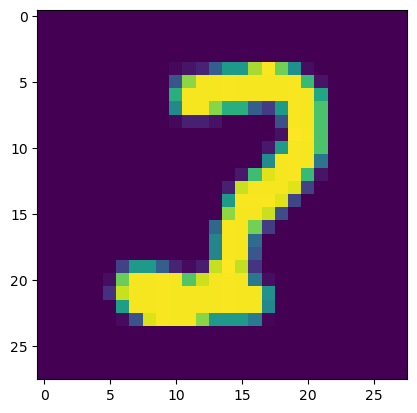

In [86]:
plt.imshow(img_tens[0, :, :])

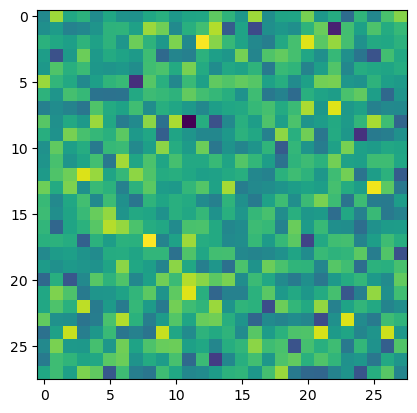

In [88]:

plt.imshow(torch.reshape(rec_sample, (28,28)).detach().numpy())


In [11]:
def elbo(x_i, mu: Tensor, sigma: Tensor, log_prob: Tensor):
    # TODO: implement log prob --> what is this? is this just the pdf evaluated at this point? 
    loss: Tensor = Tensor([0])
    log_sigma_square: Tensor = torch.log(torch.square(sigma))
    ones: Tensor = torch.ones(log_sigma_square.size())
    mu_square: Tensor = torch.square(mu)
    sigma_square: Tensor = torch.square(sigma)
    return 1/2 * torch.sum(ones + log_sigma_square - mu_square - sigma_square) + log_prob

In [12]:
def train(data: Tensor, epochs: int, vae: VAE):
    optim: torch.optim.Adam = torch.optim.Adam(params=vae.parameters(), lr=0.001)
    enc: Encoder = vae.enc
    dec: Decoder = vae.dec

    xs: List = [] #TODO data add 
    for epoch in range(epochs):
        for x in xs:
            enc_mu_sigma: Tuple[Tensor, Tensor] = enc.__forward__(x)



    return None

In [13]:
norm = torch.distributions.Normal(0,1)

In [14]:
torch.exp(norm.log_prob(Tensor([0])))

tensor([0.3989])